In [1]:
import os
import numpy as np
import cv2
import pandas as pd

# utils imports
import scipy.io as sio
import math
from math import cos, sin

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms
import torchvision
import torch.utils.model_zoo as model_zoo

import matplotlib.pyplot as plt

from PIL import Image, ImageFilter

# Utils

In [2]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    with open(file_path) as f:
        lines = f.read().splitlines()
    return lines

In [3]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    #print(f'this is the mat file fot sample {mat_path} : {mat}')
    pt2d = mat['pt2d']
    return pt2d

In [4]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [5]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [6]:
def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    # Input is a cv2 image
    # pose_params: (pitch, yaw, roll, tdx, tdy)
    # Where (tdx, tdy) is the translation of the face.
    # For pose we have [pitch yaw roll tdx tdy tdz scale_factor]

    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180
    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

In [7]:
# ceate filesname file for dataset calss
def filter_samples(mat_path):
    '''
    neglect the samples with angel outside the angles range [-99, 99]
    paramters
    ---------
    mat_path : str, path for sample mat file that contains angel informations
    '''
    pose = get_ypr_from_mat(mat_path)
    pitch = pose[0] * 180 / np.pi
    yaw = pose[1] * 180 / np.pi
    roll = pose[2] * 180 / np.pi

    valid = (np.abs(pitch) > 99 or
           np.abs(yaw) > 99 or
           np.abs(roll) > 99)

    return valid

def find_filenams(imgs_folders, imgs_subfolders, filename_path):
    '''
    create file with the names of the training samples for 300W_LP dataset
    '''
    with open(f'{filename_path}/filename_list.txt', 'w') as names_file:
        valid_samples = 0
        for folder in imgs_subfolders:
            print(f'processing folder {folder}')
            for img_name in os.listdir(f'{imgs_folders}/{folder}') :
                # not image
                if not img_name.endswith('.jpg'): continue 
                file_name = f'{imgs_folders}/{folder}/{img_name.replace(".jpg","")}'
                # check tha angle range 
                if filter_samples(f'{file_name}.mat'): continue
                # save the sample
                names_file.write(f'{folder}/{img_name.replace(".jpg","")}\n')
                valid_samples += 1
                
        print(f'number of valid samples is {valid_samples}')

In [8]:
'''# creat the filenmae for 300W_LP Dataset without flipping dataset
SUBFOLDERS = ['AFW', 'HELEN', 'LFPW', 'IBUG']
imgs_folders = 'dataset/300W_LP'
filename_path = imgs_folders
find_filenams(imgs_folders, SUBFOLDERS, filename_path)'''

"# creat the filenmae for 300W_LP Dataset without flipping dataset\nSUBFOLDERS = ['AFW', 'HELEN', 'LFPW', 'IBUG']\nimgs_folders = 'dataset/300W_LP'\nfilename_path = imgs_folders\nfind_filenams(imgs_folders, SUBFOLDERS, filename_path)"

In [9]:
def write_to_file(file_path, data_list):
    with open(file_path,'w') as file:
        for item in data_list:
            file.write(item + '\n')

# split dataset
def split_dataset(filenames_list_path, training_pres = .9):
    # get file names
    filenames = get_list_from_filenames(filenames_list_path + '/filename_list.txt')
    # ranbomly shuffel dataset
    np.random.shuffle(filenames)
    num_training = int(len(filenames) * training_pres)
    print(f'number of training samples is {num_training}')
    train_dataset = filenames[:num_training]
    val_dataset = filenames[:num_training]
    # save splits
    write_to_file(filenames_list_path + '/filename_list_train.txt', train_dataset)
    write_to_file(filenames_list_path + '/filename_list_val.txt', val_dataset)    

In [10]:
'''split_dataset('dataset/300W_LP', training_pres = .9)'''

"split_dataset('dataset/300W_LP', training_pres = .9)"

# DataSet

In [11]:
class Pose_300W_LP(Dataset):
    # Head pose from 300W-LP dataset
    def __init__(self, data_dir, filename_path, transform, augment=True, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.transform = transform
        self.augment = augment
        self.img_ext = img_ext
        self.annot_ext = annot_ext
        # get the images subfolder/name
        filename_list = get_list_from_filenames(filename_path)

        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        # load image
        img = Image.open(f'{self.data_dir}/{self.X_train[index]}{self.img_ext}')
        img = img.convert(self.image_mode)
        # load lables
        mat_path = f'{self.data_dir}/{self.y_train[index]}{self.annot_ext}'

        # Crop the face loosely
        # get the image 2D facila points
        pt2d = get_pt2d_from_mat(mat_path)
        # find the face BBOX form facila points
        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])
        
        # adjust the face BBOX to more sutable size
        
        # k = 0.2 to 0.40 I the BBOX scaling factor
        # increase the size of the BBOX for, .12 * 2, .24 * 2
        # but the size for y_min is scaled more as the min point in 2D is eyes
        # fix k size during evaluation
        if self.augment: k = np.random.random_sample() * 0.2 + 0.2
        else : k = .3
        x_min -= 0.6 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min) 
        x_max += 0.6 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi

        # Flip Augmentaion
        rnd = np.random.random_sample()
        if rnd < 0.5 and self.augment:
            yaw = -yaw
            roll = -roll
            img = img.transpose(Image.FLIP_LEFT_RIGHT)

        # Blur Augmentaion
        rnd = np.random.random_sample()
        if rnd < 0.05 and self.augment:
            img = img.filter(ImageFilter.BLUR)

        # Bin values
        bins = np.array(range(-99, 102, 3)) # [-99, 99]
        # output: array(1*3) value[0, 66[, the number of the region each angle in
        binned_pose = np.digitize([yaw, pitch, roll], bins) - 1

        # Get target tensors
        labels = binned_pose
        angles = torch.FloatTensor([yaw, pitch, roll])

        if self.transform is not None:
            img = self.transform(img)
        else :
            img = transforms.ToTensor()(img)

        return img, labels, angles, self.X_train[index]

    def __len__(self):
        # 61,225 without flipping data
        return self.length

(240, 240, 3) <class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


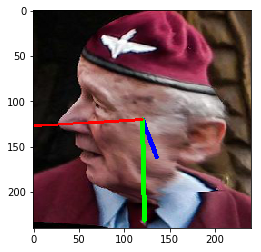

In [12]:
# test dataset
dataset = Pose_300W_LP(data_dir = '../dataset/300W_LP', filename_path = '../dataset/300W_LP/filename_list.txt', transform = None)
dl = DataLoader(dataset, batch_size=1, shuffle=True)

for img, dig_labels, exact_labels, img_path in dl:
    img, dig_labels, exact_labels, img_path = img[0], dig_labels[0], exact_labels[0], img_path[0]
    # draw the head pose estimation axes
    image = img.permute((1,2,0)).numpy()
    image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
    #image = cv2.imread(os.path.join('dataset/300W_LP', img_path + '.jpg'))
    print(image.shape, type(image))
    draw_axis(image, exact_labels[0], exact_labels[1], exact_labels[2], 
              tdx = image.shape[1] / 2, tdy= (image.shape[0]) / 2, size = image.shape[0]/2)
    plt.imshow(image)
    break

# Arch

In [13]:
class Hopenet(nn.Module):
    # Hopenet with 3 output layers for yaw, pitch and roll
    # Predicts Euler angles by binning and regression with the expected value
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(Hopenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll

# Train

## Logger

In [14]:
import tensorflow as tf


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def add_scalar(self, tag, value, global_step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, global_step)

In [15]:
# create logger file
logger = Logger('log_dir')

## variables 

In [16]:
num_epochs = 25
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoints_file = 'checkpoints'
last_checkpoint = f'{checkpoints_file}/headpose_last.pth'
best_checkpoint = f'{checkpoints_file}/headpose_best.pth'
best_checkpoint_acc = f'{checkpoints_file}/headpose_best_acc.pth'
# create checkpoints file
os.makedirs(checkpoints_file, exist_ok=True)
# dataset variables
data_dir = '../dataset/300W_LP'
filename_list_train = f'{data_dir}/filename_list_train.txt'
filename_list_val = f'{data_dir}/filename_list_val.txt'

lr = 0.00001

best_loss = 1e6
best_acc = 0

alpha = 1

In [17]:
device

'cuda'

## Helper Functions

In [18]:
def get_ignored_params(model):
    # Generator function that yields ignored params.
    b = [model.conv1, model.bn1, model.fc_finetune]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_non_ignored_params(model):
    # Generator function that yields params that will be optimized.
    b = [model.layer1, model.layer2, model.layer3, model.layer4]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_fc_params(model):
    # Generator function that yields fc layer params.
    b = [model.fc_yaw, model.fc_pitch, model.fc_roll]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            for name, param in module.named_parameters():
                yield param

def load_filtered_state_dict(model, snapshot):
    # By user apaszke from discuss.pytorch.org
    model_dict = model.state_dict()
    snapshot = {k: v for k, v in snapshot.items() if k in model_dict}
    model_dict.update(snapshot)
    model.load_state_dict(model_dict)

In [19]:
# intialize model
# ResNet50 structure
model = Hopenet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)
model.to(device)
softmax = nn.Softmax(dim=1).to(device)

In [20]:
# load checkpoint
if os.path.exists(last_checkpoint):
    print(f'loaded Last Checkpoint')
    saved_state_dict = torch.load(last_checkpoint)
    model.load_state_dict(saved_state_dict['state_dic'])
else:
    # load ImageNet weights
    print(f'loaded ImgNet weights')
    load_filtered_state_dict(model, model_zoo.load_url(torchvision.models.resnet.model_urls['resnet50']))

loaded ImgNet weights


In [21]:
# load best checkpoint and copy best_loss, best_AP
if os.path.exists(best_checkpoint): 
    check = torch.load(best_checkpoint)
    best_loss = check['val_loss']
    print(f'checkpoint from epoch ' + str(check['epoch']))
    print(f'checkpoint with loss ' + str(best_loss))
    print(f'checkpoint with score ' + str(check['score']))

if os.path.exists(best_checkpoint_acc): 
    check = torch.load(best_checkpoint_acc)
    best_score = check['score']
    print(f'checkpoint from epoch ' + str(check['epoch']))
    print(f'checkpoint with loss ' + str(check['val_loss']))
    print(f'checkpoint with score ' + str(best_score))

checkpoint from epoch 1
checkpoint with loss 0.0478086821513965
checkpoint with score 0.005372244348318657
checkpoint from epoch 0
checkpoint with loss 0.04783951984785035
checkpoint with score 0.005377373349167131


In [22]:
# dataset transformer
transformations = {}
transformations['train'] = transforms.Compose([transforms.Resize(240),
                                      transforms.RandomCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transformations['val'] = transforms.Compose([transforms.Resize(240),
                                      transforms.CenterCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# create training dataloader
pose_train = Pose_300W_LP(data_dir, filename_list_train, transform=transformations['train'], augment=True)
train_loader = DataLoader(pose_train, batch_size=batch_size, shuffle=True)

# create val dataloader
pose_val = Pose_300W_LP(data_dir, filename_list_val, transform=transformations['val'], augment=False)
val_loader = DataLoader(pose_val, batch_size=batch_size, shuffle=False)

In [23]:
# loss for softmax prediction
cls_criterion = nn.CrossEntropyLoss().to(device)
#loss of Regression fine tuning
reg_criterion = nn.MSELoss().to(device)

# optimizer, set three diffrent lr through the network
optimizer = torch.optim.Adam([{'params': get_ignored_params(model), 'lr': 0},
                              {'params': get_non_ignored_params(model), 'lr': lr},
                              {'params': get_fc_params(model), 'lr': lr * 5}],
                               lr = lr)

## training

In [ ]:
def get_reg_form_cls(pred, prop_func, device):
    # compute predected prop
    pred_prop = softmax(pred)
    # get regression value for proplities
    idx_tensor = torch.FloatTensor([idx for idx in range(66)]).to(device)
    reg_pred = torch.sum(pred_prop * idx_tensor, dim=1) * 3 - 99 # [-99, 99]
    return reg_pred

In [ ]:
def train_epoch(model, prop_func, optimizer, train_loader, logger, epoch_num, 
                cls_criterion, reg_criterion, disp_every, device):
    
    # values to compute
    total_loss = 0
    total_loss_perAng = [0, 0, 0] # yaw, pitch, roll
    total_acc_perAng = [0, 0, 0] # yaw, pitch, roll
    dataset_size = len(train_loader.dataset)
    
    for i, (img, bins_angles, angles, img_name) in enumerate(train_loader):
        
        # load to device 
        img = img.to(device)
        angles = angles.to(device)
        bins_angles = bins_angles.to(device)
        
        # pass image to the model
        pred_yaw, pred_pitch, pred_roll = model(img)
        
        # compute classification losses
        loss_cls_yaw = cls_criterion(pred_yaw, bins_angles[:, 0])
        loss_cls_pitch = cls_criterion(pred_pitch, bins_angles[:, 1])        
        loss_cls_roll = cls_criterion(pred_roll, bins_angles[:, 2])
        
        # get the regression values for the output of the model
        reg_yaw = get_reg_form_cls(pred_yaw, prop_func, device)
        reg_pitch = get_reg_form_cls(pred_pitch, prop_func, device)
        reg_roll = get_reg_form_cls(pred_roll, prop_func, device)
        
        # computer regression losses 
        loss_reg_yaw = reg_criterion(reg_yaw, angles[:, 0])
        loss_reg_pitch = reg_criterion(reg_pitch, angles[:, 1])        
        loss_reg_roll = reg_criterion(reg_roll, angles[:, 2])
        
        # total losses 
        loss_yaw = loss_cls_yaw + alpha * loss_reg_yaw
        loss_pitch = loss_cls_pitch + alpha * loss_reg_pitch        
        loss_roll = loss_cls_roll + alpha * loss_reg_roll
        
        # backprop and optimize 
        loss = loss_yaw + loss_pitch + loss_roll
        optimizer.zero_grad()
        loss.backward()
        # grad clipping, (max_norm=5.0) 
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        # compute total loss
        total_loss += loss.cpu().detach().numpy()
        total_loss_perAng[0] += loss_yaw.cpu().detach().numpy() * batch_size
        total_loss_perAng[1] += loss_pitch.cpu().detach().numpy() * batch_size
        total_loss_perAng[2] += loss_roll.cpu().detach().numpy() * batch_size
        
        # compute Accuracy
        total_acc_perAng[0] += torch.sum(torch.abs(reg_yaw - angles[:, 0])).cpu().detach().numpy()
        total_acc_perAng[1] += torch.sum(torch.abs(reg_pitch - angles[:, 1])).cpu().detach().numpy()    
        total_acc_perAng[2] += torch.sum(torch.abs(reg_roll - angles[:, 2])).cpu().detach().numpy()
        
        # print results and save to logger
        if i % disp_every == 0:
            print(f'Epoch[{epoch_num}], Itr[{i}/{len(train_loader)}], \
            Losses: Yaw {loss_yaw:.2f}, Pitch {loss_pitch:.2f}, Roll {loss_roll:.2f}')

            
    # finish epoch
    total_acc_perAng = [x/dataset_size for x in total_acc_perAng]
    total_loss_perAng = [x/dataset_size for x in total_loss_perAng]
    total_loss /= dataset_size
    print(f'\nEpoch[{epoch_num}] Total Loss: {total_loss}\n\
    Losses Per Angle: Yaw {total_loss_perAng[0]:.2f}, Pitch {total_loss_perAng[1]:.2f}, Roll {total_loss_perAng[2]:.2f}\n\
    Acc Per Angle: Yaw {total_acc_perAng[0]:.2f}, Pitch {total_acc_perAng[1]:.2f}, Roll {total_acc_perAng[2]:.2f}')
    
    # add to logger 
    logger.add_scalar('Total_Train_Losses/total_loss', total_loss, global_step=epoch_num)
    # losses per angle
    logger.add_scalar('Total_Train_Losses/Yaw', total_loss_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Train_Losses/Pitch', total_loss_perAng[1],global_step=epoch_num)        
    logger.add_scalar('Total_Train_Losses/Roll', total_loss_perAng[2],global_step=epoch_num)
    #acc per angle
    logger.add_scalar('Total_Train_Acc/Yaw', total_acc_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Train_Acc/Pitch', total_acc_perAng[1],global_step=epoch_num)        
    logger.add_scalar('Total_Train_Acc/Roll', total_acc_perAng[2],global_step=epoch_num)

In [ ]:
def evaluate(model, prop_func, val_loader, logger, epoch_num, 
                cls_criterion, reg_criterion, disp_every, device):
    
    print(f'Evaluating Epoch {epoch_num} ....')
    
    # values to compute
    total_loss = 0
    total_loss_perAng = [0, 0, 0] # yaw, pitch, roll
    total_acc_perAng = [0, 0, 0] # yaw, pitch, roll
    dataset_size = len(train_loader.dataset)
    
    for i, (img, bins_angles, angles, img_name) in enumerate(val_loader):
        
        # load to device 
        img = img.to(device)
        angles = angles.to(device)
        bins_angles = bins_angles.to(device)
        
        with torch.no_grad():
            # pass image to the model
            pred_yaw, pred_pitch, pred_roll = model(img)
        
        # compute classification losses
        loss_cls_yaw = cls_criterion(pred_yaw, bins_angles[:, 0])
        loss_cls_pitch = cls_criterion(pred_pitch, bins_angles[:, 1])        
        loss_cls_roll = cls_criterion(pred_roll, bins_angles[:, 2])
        
        # get the regression values for the output of the model
        reg_yaw = get_reg_form_cls(pred_yaw, prop_func, device)
        reg_pitch = get_reg_form_cls(pred_pitch, prop_func, device)
        reg_roll = get_reg_form_cls(pred_roll, prop_func, device)
        
        # computer regression losses 
        loss_reg_yaw = reg_criterion(reg_yaw, angles[:, 0])
        loss_reg_pitch = reg_criterion(reg_pitch, angles[:, 1])        
        loss_reg_roll = reg_criterion(reg_roll, angles[:, 2])
        
        # total losses 
        loss_yaw = loss_cls_yaw + alpha * loss_reg_yaw
        loss_pitch = loss_cls_pitch + alpha * loss_reg_pitch        
        loss_roll = loss_cls_roll + alpha * loss_reg_roll
        
        loss = loss_yaw + loss_pitch + loss_roll
        
        # compute total loss
        total_loss += loss.cpu().detach().numpy()
        total_loss_perAng[0] += loss_yaw.cpu().detach().numpy() * batch_size
        total_loss_perAng[1] += loss_pitch.cpu().detach().detach().numpy() * batch_size
        total_loss_perAng[2] += loss_roll.cpu().detach().numpy() * batch_size
        
        # compute Accuracy
        total_acc_perAng[0] += torch.sum(torch.abs(reg_yaw - angles[:, 0])).cpu().detach().numpy()
        total_acc_perAng[1] += torch.sum(torch.abs(reg_pitch - angles[:, 1])).cpu().detach().numpy()
        total_acc_perAng[2] += torch.sum(torch.abs(reg_roll - angles[:, 2])).cpu().detach().numpy()
        
        # print results and save to logger
        if i % disp_every == 0:
            print(f'Processing in Itr[{i}/{len(train_loader)}], \
            Losses: Yaw {loss_yaw:.2f}, Pitch {loss_pitch:.2f}, Roll {loss_roll:.2f}')
            
            
    # finish epoch
    total_acc_perAng = [x/dataset_size for x in total_acc_perAng]
    total_loss_perAng = [x/dataset_size for x in total_loss_perAng]
    total_loss /= dataset_size
    print(f'\nEpoch[{epoch_num}] Total Loss: {total_loss}\n\
    Losses Per Angle: Yaw {total_loss_perAng[0]:.2f}, Pitch {total_loss_perAng[1]:.2f}, Roll {total_loss_perAng[2]:.2f}\n\
    Acc Per Angle: Yaw {total_acc_perAng[0]:.2f}, Pitch {total_acc_perAng[1]:.2f}, Roll {total_acc_perAng[2]:.2f}')

    # add to logger 
    logger.add_scalar('Total_Val_Losses/total_loss', total_loss, global_step=epoch_num)
    # losses per angle
    logger.add_scalar('Total_Val_Losses/Yaw', total_loss_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Val_Losses/Pitch', total_loss_perAng[1],global_step=epoch_num)        
    logger.add_scalar('Total_Val_Losses/Roll', total_loss_perAng[2],global_step=epoch_num)
    #acc per angle
    logger.add_scalar('Total_Val_Acc/Yaw', total_acc_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Val_Acc/Pitch', total_acc_perAng[1],global_step=epoch_num)
    logger.add_scalar('Total_Val_Acc/Roll', total_acc_perAng[2],global_step=epoch_num)
    
    return total_loss, sum(total_acc_perAng)/3

In [ ]:
# train 
for epoch in range(num_epochs):
    # train for one epoch
    train_epoch(model, softmax, optimizer, train_loader, logger, epoch, 
                cls_criterion, reg_criterion, 10, device)
    # save last checkpoint
    checkpoint = {'optim_dic':optimizer.state_dict(),
                  'state_dic':model.state_dict(),
                  'epoch':epoch
                  }
    torch.save(checkpoint, f'{checkpoints_file}/headpose_last.pth')
    
    # evaluate this epoch
    total_loss, total_acc = evaluate(model, softmax, val_loader, logger, epoch, 
             cls_criterion, reg_criterion, 10, device)
    # save best checkpoint
    if total_loss < best_loss:
        # save best loss checkpoint
        checkpoint_val = {'optim_dic':optimizer.state_dict(),
                    'state_dic':model.state_dict(),
                    'epoch':epoch,
                    'val_loss':total_loss,
                    'score': total_acc
                    }
        best_loss = total_loss
        torch.save(checkpoint_val, f'{checkpoints_file}/headpose_best.pth')
        print('found better loss')

    if total_acc > best_acc:
        # save best score checkpoint
        checkpoint_val_acc = {'optim_dic':optimizer.state_dict(),
                    'state_dic':model.state_dict(),
                    'epoch':epoch,
                    'val_loss':total_loss,
                    'score': total_acc
                    }
        best_acc = total_acc
        torch.save(checkpoint_val_acc, f'{checkpoints_file}/headpose_best_acc.pth')
        print('found better acc')

Epoch[0], Itr[0/3444],             Losses: Yaw 2590.762939453125, Pitch 159.28855895996094, Roll 96.54707336425781
Epoch[0], Itr[10/3444],             Losses: Yaw 3297.931396484375, Pitch 277.7386169433594, Roll 91.20061492919922
Epoch[0], Itr[20/3444],             Losses: Yaw 804.69677734375, Pitch 88.08460998535156, Roll 117.78172302246094
Epoch[0], Itr[30/3444],             Losses: Yaw 573.2235717773438, Pitch 158.2878875732422, Roll 79.5255126953125
Epoch[0], Itr[40/3444],             Losses: Yaw 638.0615844726562, Pitch 82.46820068359375, Roll 107.4404525756836
Epoch[0], Itr[50/3444],             Losses: Yaw 153.98013305664062, Pitch 379.45782470703125, Roll 118.02794647216797
Epoch[0], Itr[60/3444],             Losses: Yaw 142.66160583496094, Pitch 227.22610473632812, Roll 101.10234069824219
Epoch[0], Itr[70/3444],             Losses: Yaw 108.07896423339844, Pitch 91.68283081054688, Roll 73.32744598388672
Epoch[0], Itr[80/3444],             Losses: Yaw 135.00047302246094, Pitch 1

Epoch[0], Itr[700/3444],             Losses: Yaw 44.91121292114258, Pitch 56.679351806640625, Roll 53.72542190551758
Epoch[0], Itr[710/3444],             Losses: Yaw 27.8795166015625, Pitch 42.30155944824219, Roll 33.120574951171875
Epoch[0], Itr[720/3444],             Losses: Yaw 117.45507049560547, Pitch 21.433034896850586, Roll 27.551361083984375
Epoch[0], Itr[730/3444],             Losses: Yaw 88.12487030029297, Pitch 34.565467834472656, Roll 57.343772888183594
Epoch[0], Itr[740/3444],             Losses: Yaw 76.79906463623047, Pitch 30.241952896118164, Roll 50.79914093017578
Epoch[0], Itr[750/3444],             Losses: Yaw 16.974618911743164, Pitch 74.97127532958984, Roll 95.17231750488281
Epoch[0], Itr[760/3444],             Losses: Yaw 42.85009765625, Pitch 81.19580078125, Roll 32.6112060546875
Epoch[0], Itr[770/3444],             Losses: Yaw 45.163482666015625, Pitch 59.50191116333008, Roll 41.145809173583984
Epoch[0], Itr[780/3444],             Losses: Yaw 15.777902603149414, 

Epoch[0], Itr[1390/3444],             Losses: Yaw 137.61094665527344, Pitch 23.164844512939453, Roll 7.744924545288086
Epoch[0], Itr[1400/3444],             Losses: Yaw 26.888031005859375, Pitch 67.97815704345703, Roll 19.74484634399414
Epoch[0], Itr[1410/3444],             Losses: Yaw 31.899398803710938, Pitch 26.926624298095703, Roll 51.02545166015625
Epoch[0], Itr[1420/3444],             Losses: Yaw 21.450725555419922, Pitch 28.248756408691406, Roll 18.43233299255371
Epoch[0], Itr[1430/3444],             Losses: Yaw 18.072738647460938, Pitch 34.8150749206543, Roll 15.906123161315918
Epoch[0], Itr[1440/3444],             Losses: Yaw 25.026350021362305, Pitch 35.20164489746094, Roll 36.87458801269531
Epoch[0], Itr[1450/3444],             Losses: Yaw 8.757796287536621, Pitch 30.790739059448242, Roll 18.488243103027344
Epoch[0], Itr[1460/3444],             Losses: Yaw 26.50861358642578, Pitch 36.608829498291016, Roll 23.904287338256836
Epoch[0], Itr[1470/3444],             Losses: Yaw 1

Epoch[0], Itr[2080/3444],             Losses: Yaw 12.197098731994629, Pitch 38.5517692565918, Roll 18.27848243713379
Epoch[0], Itr[2090/3444],             Losses: Yaw 9.63071060180664, Pitch 22.275619506835938, Roll 10.945099830627441
Epoch[0], Itr[2100/3444],             Losses: Yaw 17.61577796936035, Pitch 40.54121780395508, Roll 33.0369873046875
Epoch[0], Itr[2110/3444],             Losses: Yaw 15.035601615905762, Pitch 17.94920539855957, Roll 14.309215545654297
Epoch[0], Itr[2120/3444],             Losses: Yaw 13.289117813110352, Pitch 22.21297836303711, Roll 21.364585876464844
Epoch[0], Itr[2130/3444],             Losses: Yaw 16.969348907470703, Pitch 21.75292205810547, Roll 17.400653839111328
Epoch[0], Itr[2140/3444],             Losses: Yaw 38.087039947509766, Pitch 115.94796752929688, Roll 60.776702880859375
Epoch[0], Itr[2150/3444],             Losses: Yaw 10.009078979492188, Pitch 35.1148567199707, Roll 40.617679595947266
Epoch[0], Itr[2160/3444],             Losses: Yaw 8.08

Epoch[0], Itr[2770/3444],             Losses: Yaw 8.830205917358398, Pitch 13.76241397857666, Roll 9.242748260498047
Epoch[0], Itr[2780/3444],             Losses: Yaw 17.902015686035156, Pitch 13.467533111572266, Roll 12.735184669494629
Epoch[0], Itr[2790/3444],             Losses: Yaw 35.11808395385742, Pitch 22.732091903686523, Roll 10.805367469787598
Epoch[0], Itr[2800/3444],             Losses: Yaw 17.312524795532227, Pitch 49.23927307128906, Roll 28.57068634033203
Epoch[0], Itr[2810/3444],             Losses: Yaw 8.73654556274414, Pitch 21.576213836669922, Roll 21.467451095581055
Epoch[0], Itr[2820/3444],             Losses: Yaw 14.942145347595215, Pitch 14.311592102050781, Roll 15.648419380187988
Epoch[0], Itr[2830/3444],             Losses: Yaw 13.837050437927246, Pitch 39.203712463378906, Roll 41.544883728027344
Epoch[0], Itr[2840/3444],             Losses: Yaw 13.92601203918457, Pitch 17.56203269958496, Roll 13.18253231048584
Epoch[0], Itr[2850/3444],             Losses: Yaw 1

    Acc Per Angle: Yaw 3.607148170609651, Pitch 4.304962933680084, Roll 3.7433662925120132
Evaluating Epoch 0 ....
Processing in Itr[0/3444],             Losses: Yaw 9.289273262023926, Pitch 14.925542831420898, Roll 10.616158485412598
Processing in Itr[10/3444],             Losses: Yaw 7.815264701843262, Pitch 25.160804748535156, Roll 8.561487197875977
Processing in Itr[20/3444],             Losses: Yaw 9.737159729003906, Pitch 18.372447967529297, Roll 11.557939529418945
Processing in Itr[30/3444],             Losses: Yaw 10.69730281829834, Pitch 15.545007705688477, Roll 7.611274719238281
Processing in Itr[40/3444],             Losses: Yaw 5.7477521896362305, Pitch 15.316171646118164, Roll 4.974632263183594
Processing in Itr[50/3444],             Losses: Yaw 9.143375396728516, Pitch 16.974212646484375, Roll 21.399768829345703
Processing in Itr[60/3444],             Losses: Yaw 9.101217269897461, Pitch 15.216019630432129, Roll 7.5027618408203125
Processing in Itr[70/3444],             L

Processing in Itr[660/3444],             Losses: Yaw 7.456357955932617, Pitch 15.54749870300293, Roll 8.691967964172363
Processing in Itr[670/3444],             Losses: Yaw 8.068648338317871, Pitch 14.222116470336914, Roll 6.801839351654053
Processing in Itr[680/3444],             Losses: Yaw 15.295563697814941, Pitch 12.92669677734375, Roll 18.472537994384766
Processing in Itr[690/3444],             Losses: Yaw 11.362398147583008, Pitch 14.932995796203613, Roll 13.588892936706543
Processing in Itr[700/3444],             Losses: Yaw 21.120174407958984, Pitch 17.027502059936523, Roll 10.702606201171875
Processing in Itr[710/3444],             Losses: Yaw 9.017395973205566, Pitch 18.393388748168945, Roll 10.245203018188477
Processing in Itr[720/3444],             Losses: Yaw 6.869498252868652, Pitch 16.038738250732422, Roll 14.932101249694824
Processing in Itr[730/3444],             Losses: Yaw 13.092568397521973, Pitch 18.77304458618164, Roll 14.198929786682129
Processing in Itr[740/344

Processing in Itr[1330/3444],             Losses: Yaw 11.35257339477539, Pitch 16.623769760131836, Roll 23.588003158569336
Processing in Itr[1340/3444],             Losses: Yaw 8.129070281982422, Pitch 17.03594207763672, Roll 8.39963150024414
Processing in Itr[1350/3444],             Losses: Yaw 8.09229850769043, Pitch 12.441244125366211, Roll 17.91994285583496
Processing in Itr[1360/3444],             Losses: Yaw 8.836766242980957, Pitch 19.105451583862305, Roll 8.909791946411133
Processing in Itr[1370/3444],             Losses: Yaw 9.051129341125488, Pitch 11.153230667114258, Roll 6.743005752563477
Processing in Itr[1380/3444],             Losses: Yaw 7.552427291870117, Pitch 16.685293197631836, Roll 8.306185722351074
Processing in Itr[1390/3444],             Losses: Yaw 11.237037658691406, Pitch 22.18447494506836, Roll 19.697019577026367
Processing in Itr[1400/3444],             Losses: Yaw 7.8864593505859375, Pitch 12.712968826293945, Roll 8.074441909790039
Processing in Itr[1410/3

Processing in Itr[2000/3444],             Losses: Yaw 8.142234802246094, Pitch 19.708171844482422, Roll 16.92763900756836
Processing in Itr[2010/3444],             Losses: Yaw 13.79617691040039, Pitch 17.095348358154297, Roll 28.478782653808594
Processing in Itr[2020/3444],             Losses: Yaw 9.9417724609375, Pitch 10.98710823059082, Roll 8.601822853088379
Processing in Itr[2030/3444],             Losses: Yaw 8.091145515441895, Pitch 22.564495086669922, Roll 13.027008056640625
Processing in Itr[2040/3444],             Losses: Yaw 6.897747039794922, Pitch 36.649635314941406, Roll 24.002944946289062
Processing in Itr[2050/3444],             Losses: Yaw 7.649997711181641, Pitch 32.020538330078125, Roll 16.16112518310547
Processing in Itr[2060/3444],             Losses: Yaw 6.844532012939453, Pitch 12.196027755737305, Roll 10.276583671569824
Processing in Itr[2070/3444],             Losses: Yaw 7.596704483032227, Pitch 14.466943740844727, Roll 14.383285522460938
Processing in Itr[2080

Processing in Itr[2670/3444],             Losses: Yaw 9.686521530151367, Pitch 24.662151336669922, Roll 28.671558380126953
Processing in Itr[2680/3444],             Losses: Yaw 9.211688995361328, Pitch 10.87484073638916, Roll 13.518328666687012
Processing in Itr[2690/3444],             Losses: Yaw 5.911587715148926, Pitch 8.215635299682617, Roll 10.360773086547852
Processing in Itr[2700/3444],             Losses: Yaw 6.938425064086914, Pitch 13.899910926818848, Roll 9.762712478637695
Processing in Itr[2710/3444],             Losses: Yaw 5.478800296783447, Pitch 15.669748306274414, Roll 20.315155029296875
Processing in Itr[2720/3444],             Losses: Yaw 9.42602825164795, Pitch 33.5413703918457, Roll 55.74765396118164
Processing in Itr[2730/3444],             Losses: Yaw 10.106599807739258, Pitch 18.361703872680664, Roll 14.111133575439453
Processing in Itr[2740/3444],             Losses: Yaw 7.663010597229004, Pitch 22.520353317260742, Roll 18.164762496948242
Processing in Itr[2750

Processing in Itr[3340/3444],             Losses: Yaw 8.210493087768555, Pitch 9.859132766723633, Roll 9.498554229736328
Processing in Itr[3350/3444],             Losses: Yaw 7.365018367767334, Pitch 28.928600311279297, Roll 6.649768829345703
Processing in Itr[3360/3444],             Losses: Yaw 7.026684761047363, Pitch 12.890033721923828, Roll 5.493292808532715
Processing in Itr[3370/3444],             Losses: Yaw 6.89393424987793, Pitch 7.160634517669678, Roll 7.841737270355225
Processing in Itr[3380/3444],             Losses: Yaw 8.606098175048828, Pitch 16.116493225097656, Roll 12.226496696472168
Processing in Itr[3390/3444],             Losses: Yaw 6.754148006439209, Pitch 14.511554718017578, Roll 7.752564907073975
Processing in Itr[3400/3444],             Losses: Yaw 9.914505958557129, Pitch 16.891944885253906, Roll 14.348243713378906
Processing in Itr[3410/3444],             Losses: Yaw 7.562613010406494, Pitch 16.105548858642578, Roll 15.654539108276367
Processing in Itr[3420/3

Epoch[1], Itr[560/3444],             Losses: Yaw 9.138437271118164, Pitch 16.357402801513672, Roll 17.137611389160156
Epoch[1], Itr[570/3444],             Losses: Yaw 10.776371955871582, Pitch 23.717525482177734, Roll 21.064271926879883
Epoch[1], Itr[580/3444],             Losses: Yaw 10.243061065673828, Pitch 13.897841453552246, Roll 10.79617977142334
Epoch[1], Itr[590/3444],             Losses: Yaw 8.216330528259277, Pitch 43.191871643066406, Roll 17.90938377380371
Epoch[1], Itr[600/3444],             Losses: Yaw 8.20969295501709, Pitch 24.941110610961914, Roll 13.0680570602417
Epoch[1], Itr[610/3444],             Losses: Yaw 12.430508613586426, Pitch 36.94114685058594, Roll 23.844497680664062
Epoch[1], Itr[620/3444],             Losses: Yaw 7.148067474365234, Pitch 7.441228866577148, Roll 6.950730800628662
Epoch[1], Itr[630/3444],             Losses: Yaw 11.740510940551758, Pitch 21.34115219116211, Roll 12.730610847473145
Epoch[1], Itr[640/3444],             Losses: Yaw 12.539355278

Epoch[1], Itr[1250/3444],             Losses: Yaw 9.194348335266113, Pitch 10.444905281066895, Roll 9.302184104919434
Epoch[1], Itr[1260/3444],             Losses: Yaw 10.339563369750977, Pitch 12.02904987335205, Roll 18.15306854248047
Epoch[1], Itr[1270/3444],             Losses: Yaw 7.293298244476318, Pitch 26.214326858520508, Roll 10.169086456298828
Epoch[1], Itr[1280/3444],             Losses: Yaw 10.369674682617188, Pitch 15.878597259521484, Roll 12.555015563964844
Epoch[1], Itr[1290/3444],             Losses: Yaw 83.99836730957031, Pitch 40.1053352355957, Roll 19.50448989868164
Epoch[1], Itr[1300/3444],             Losses: Yaw 20.171842575073242, Pitch 16.097322463989258, Roll 27.18399429321289
Epoch[1], Itr[1310/3444],             Losses: Yaw 19.158897399902344, Pitch 38.52247619628906, Roll 26.07506561279297
Epoch[1], Itr[1320/3444],             Losses: Yaw 12.374858856201172, Pitch 24.651887893676758, Roll 20.83058738708496
Epoch[1], Itr[1330/3444],             Losses: Yaw 10.

Epoch[1], Itr[1940/3444],             Losses: Yaw 6.729127883911133, Pitch 21.418004989624023, Roll 30.250539779663086
Epoch[1], Itr[1950/3444],             Losses: Yaw 13.687219619750977, Pitch 12.453084945678711, Roll 16.112268447875977
Epoch[1], Itr[1960/3444],             Losses: Yaw 12.384305953979492, Pitch 15.785776138305664, Roll 16.028968811035156
Epoch[1], Itr[1970/3444],             Losses: Yaw 11.466184616088867, Pitch 35.39240264892578, Roll 15.236954689025879
Epoch[1], Itr[1980/3444],             Losses: Yaw 12.208187103271484, Pitch 15.386528015136719, Roll 9.136287689208984
Epoch[1], Itr[1990/3444],             Losses: Yaw 14.302964210510254, Pitch 26.322603225708008, Roll 16.35521697998047
Epoch[1], Itr[2000/3444],             Losses: Yaw 9.783156394958496, Pitch 25.472246170043945, Roll 9.608484268188477
Epoch[1], Itr[2010/3444],             Losses: Yaw 18.41677474975586, Pitch 22.746925354003906, Roll 17.40216636657715
Epoch[1], Itr[2020/3444],             Losses: Ya

Epoch[1], Itr[2630/3444],             Losses: Yaw 5.933876037597656, Pitch 12.202058792114258, Roll 13.467761993408203
Epoch[1], Itr[2640/3444],             Losses: Yaw 6.404766082763672, Pitch 13.158180236816406, Roll 10.476863861083984
Epoch[1], Itr[2650/3444],             Losses: Yaw 9.620750427246094, Pitch 27.547077178955078, Roll 25.413528442382812
Epoch[1], Itr[2660/3444],             Losses: Yaw 6.498106002807617, Pitch 13.058385848999023, Roll 18.009355545043945
Epoch[1], Itr[2670/3444],             Losses: Yaw 10.392541885375977, Pitch 32.436038970947266, Roll 41.864383697509766
Epoch[1], Itr[2680/3444],             Losses: Yaw 7.847325801849365, Pitch 11.80873966217041, Roll 8.332101821899414
Epoch[1], Itr[2690/3444],             Losses: Yaw 9.999070167541504, Pitch 26.81730079650879, Roll 23.025136947631836
Epoch[1], Itr[2700/3444],             Losses: Yaw 19.412710189819336, Pitch 20.52657127380371, Roll 9.842951774597168
Epoch[1], Itr[2710/3444],             Losses: Yaw 1

Epoch[1], Itr[3320/3444],             Losses: Yaw 8.974191665649414, Pitch 10.255996704101562, Roll 6.796945095062256
Epoch[1], Itr[3330/3444],             Losses: Yaw 6.515210151672363, Pitch 26.526649475097656, Roll 17.92565155029297
Epoch[1], Itr[3340/3444],             Losses: Yaw 21.083633422851562, Pitch 21.202104568481445, Roll 10.480720520019531
Epoch[1], Itr[3350/3444],             Losses: Yaw 12.415958404541016, Pitch 9.29012393951416, Roll 7.731208801269531
Epoch[1], Itr[3360/3444],             Losses: Yaw 6.206243515014648, Pitch 10.001328468322754, Roll 11.80867862701416
Epoch[1], Itr[3370/3444],             Losses: Yaw 13.985973358154297, Pitch 22.917009353637695, Roll 20.286788940429688
Epoch[1], Itr[3380/3444],             Losses: Yaw 7.878734588623047, Pitch 16.660844802856445, Roll 11.627767562866211
Epoch[1], Itr[3390/3444],             Losses: Yaw 8.973475456237793, Pitch 16.2808780670166, Roll 9.52216911315918
Epoch[1], Itr[3400/3444],             Losses: Yaw 6.251

Processing in Itr[520/3444],             Losses: Yaw 7.133154392242432, Pitch 12.032360076904297, Roll 6.94240665435791
Processing in Itr[530/3444],             Losses: Yaw 7.301534652709961, Pitch 8.481897354125977, Roll 7.036747932434082
Processing in Itr[540/3444],             Losses: Yaw 11.56296157836914, Pitch 14.668110847473145, Roll 7.580735683441162
Processing in Itr[550/3444],             Losses: Yaw 7.018194198608398, Pitch 20.2852840423584, Roll 12.779019355773926
Processing in Itr[560/3444],             Losses: Yaw 7.825552940368652, Pitch 20.76474380493164, Roll 16.1357364654541
Processing in Itr[570/3444],             Losses: Yaw 13.766203880310059, Pitch 65.6769790649414, Roll 57.26958084106445
Processing in Itr[580/3444],             Losses: Yaw 8.527178764343262, Pitch 14.928302764892578, Roll 10.33565902709961
Processing in Itr[590/3444],             Losses: Yaw 10.30380630493164, Pitch 12.934915542602539, Roll 20.694149017333984
Processing in Itr[600/3444],         

Processing in Itr[1190/3444],             Losses: Yaw 10.328728675842285, Pitch 13.783029556274414, Roll 13.709248542785645
Processing in Itr[1200/3444],             Losses: Yaw 9.09239387512207, Pitch 4.960700988769531, Roll 8.199542999267578
Processing in Itr[1210/3444],             Losses: Yaw 8.092757225036621, Pitch 10.871853828430176, Roll 6.398220539093018
Processing in Itr[1220/3444],             Losses: Yaw 7.171131134033203, Pitch 8.829357147216797, Roll 5.892743110656738
Processing in Itr[1230/3444],             Losses: Yaw 8.083449363708496, Pitch 11.928348541259766, Roll 7.928133964538574
Processing in Itr[1240/3444],             Losses: Yaw 5.512240409851074, Pitch 20.48344612121582, Roll 9.984516143798828
Processing in Itr[1250/3444],             Losses: Yaw 7.31427001953125, Pitch 20.0544490814209, Roll 12.928540229797363
Processing in Itr[1260/3444],             Losses: Yaw 7.475559234619141, Pitch 16.98746109008789, Roll 23.52345085144043
Processing in Itr[1270/3444],

Processing in Itr[1860/3444],             Losses: Yaw 6.652493953704834, Pitch 18.767913818359375, Roll 13.645308494567871
Processing in Itr[1870/3444],             Losses: Yaw 9.322929382324219, Pitch 10.216132164001465, Roll 19.18707275390625
Processing in Itr[1880/3444],             Losses: Yaw 7.076291084289551, Pitch 18.657569885253906, Roll 14.227849006652832
Processing in Itr[1890/3444],             Losses: Yaw 11.708102226257324, Pitch 10.475381851196289, Roll 16.899009704589844
Processing in Itr[1900/3444],             Losses: Yaw 7.952167510986328, Pitch 13.550793647766113, Roll 12.060672760009766
Processing in Itr[1910/3444],             Losses: Yaw 10.500504493713379, Pitch 24.2738037109375, Roll 24.09532928466797
Processing in Itr[1920/3444],             Losses: Yaw 7.1166486740112305, Pitch 9.137615203857422, Roll 11.967018127441406
Processing in Itr[1930/3444],             Losses: Yaw 6.543927192687988, Pitch 13.275665283203125, Roll 9.65567398071289
Processing in Itr[19

Processing in Itr[2530/3444],             Losses: Yaw 9.27777099609375, Pitch 21.012086868286133, Roll 12.027865409851074
Processing in Itr[2540/3444],             Losses: Yaw 11.309181213378906, Pitch 11.835799217224121, Roll 15.375896453857422
Processing in Itr[2550/3444],             Losses: Yaw 11.98568058013916, Pitch 9.014792442321777, Roll 7.533316612243652
Processing in Itr[2560/3444],             Losses: Yaw 11.110016822814941, Pitch 25.88141632080078, Roll 35.74418640136719
Processing in Itr[2570/3444],             Losses: Yaw 10.401908874511719, Pitch 15.541023254394531, Roll 14.868106842041016
Processing in Itr[2580/3444],             Losses: Yaw 8.5352783203125, Pitch 7.190640449523926, Roll 8.489654541015625
Processing in Itr[2590/3444],             Losses: Yaw 7.414917945861816, Pitch 16.962692260742188, Roll 20.937763214111328
Processing in Itr[2600/3444],             Losses: Yaw 7.191523551940918, Pitch 18.258272171020508, Roll 13.821050643920898
Processing in Itr[2610

Processing in Itr[3200/3444],             Losses: Yaw 11.402056694030762, Pitch 28.051979064941406, Roll 27.771419525146484
Processing in Itr[3210/3444],             Losses: Yaw 13.265740394592285, Pitch 11.469414710998535, Roll 14.593135833740234
Processing in Itr[3220/3444],             Losses: Yaw 13.188825607299805, Pitch 17.832298278808594, Roll 15.869369506835938
Processing in Itr[3230/3444],             Losses: Yaw 6.6662516593933105, Pitch 11.837202072143555, Roll 10.51209545135498
Processing in Itr[3240/3444],             Losses: Yaw 9.198993682861328, Pitch 16.320449829101562, Roll 8.296978950500488
Processing in Itr[3250/3444],             Losses: Yaw 9.719640731811523, Pitch 7.589457988739014, Roll 13.092188835144043
Processing in Itr[3260/3444],             Losses: Yaw 8.39607048034668, Pitch 13.745283126831055, Roll 10.927311897277832
Processing in Itr[3270/3444],             Losses: Yaw 9.700152397155762, Pitch 10.019962310791016, Roll 8.575992584228516
Processing in Itr